<h1>
    Reiforcement Learning
</h1>
<p>
     just for the first run, don't rerun
</p>

In [33]:
tf.compat.v1.disable_eager_execution()

<h3>
    Using openAI Gym
</h3>

In [1]:
import gym
import matplotlib.pyplot as plt

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [3]:
obs = env.reset()

In [4]:
obs

(array([-0.01128341, -0.02109416,  0.04495375,  0.01851165], dtype=float32),
 {})

In [5]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [6]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")

In [7]:
env.action_space

Discrete(2)

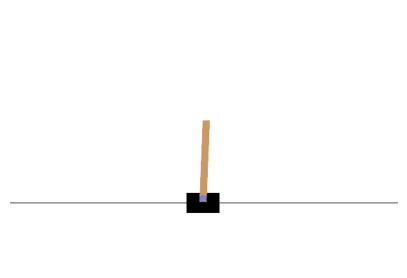

In [8]:
plot_environment(env)
plt.show()

In [9]:
action = 1

In [10]:
obs = env.reset()
while True:
    a, b, c, d, e= env.step(0)
    if c:
        break

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [11]:
env.step(0)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


(array([-0.2166479 , -1.9862353 ,  0.26567522,  3.092024  ], dtype=float32),
 0.0,
 True,
 False,
 {})

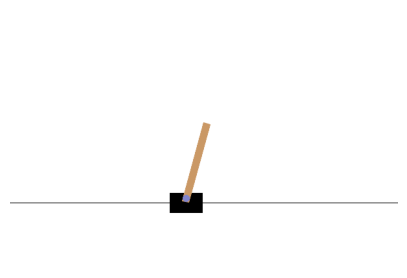

In [12]:
plot_environment(env)


In [13]:
b

1.0

In [14]:
c

True

In [15]:
env.reset()

(array([ 0.03212068,  0.00784483, -0.02238501,  0.01574199], dtype=float32),
 {})

In [16]:
action = 1 # Accelerate right

In [17]:
obs, reward, done, info, _ = env.step(action)

In [18]:
print(obs, reward, done, info)

[ 0.03227758  0.20328054 -0.02207018 -0.28391877] 1.0 False False


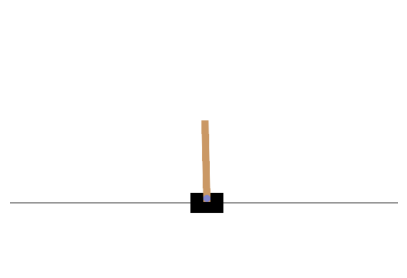

In [19]:
plot_environment(env)

<h3>
    Policy
</h3>
<p>
    When the pole is leaning towards its left, accelerate towards left;<br>
    pole leaning towards right, accelerates towards right
</p>

In [20]:
def policy(obs):
    #print(obs[0])
    angle = obs[2]
    return 0 if angle < 0 else 1

In [21]:
def policy2(obs):
    #print(obs[0])
    angle = obs[2]
    return 0 if angle < 0 else 1

In [22]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    obs = obs[:-1]
    #print(type(len(obs)))
    #print(len(obs))
    action = policy(obs[0])
    for step in range(1000):
        obs, reward, done, info, _ = env.step(action)
        episode_rewards += reward
        #plot_environment(env)
        action = policy2(obs)
        if done:
            break
    totals.append(episode_rewards)

In [160]:
action.get_shape()

TensorShape([None, 1])

In [24]:
obs[2]

0.22676802

In [25]:
obs

array([-0.1593443 , -0.74376327,  0.22676802,  0.8718364 ], dtype=float32)

In [26]:
import numpy as np

In [27]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.306, 8.810014982961153, 24.0, 67.0)

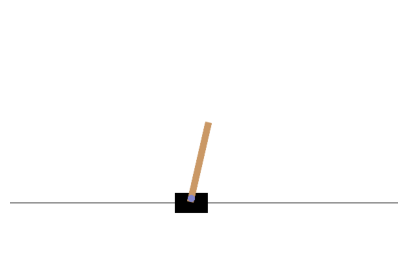

In [28]:
plot_environment(env)

<h3>
    Neural Network Policies
</h3>

In [174]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

In [175]:
env.observation_space.shape

(4,)

In [176]:
n_inputs = 4
n_hidden = 4
n_outputs = 1
initializer = tf.compat.v1.variance_scaling_initializer()
learning_rate = 0.01

In [177]:
X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
hidden = Dense(n_hidden, activation=tf.nn.elu,
                   kernel_initializer=initializer)(X)
logits = Dense(n_outputs, activation=None,
               kernel_initializer=initializer)(hidden)
outputs = tf.nn.sigmoid(logits)

In [178]:
init = tf.compat.v1.global_variables_initializer()

In [179]:
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])

In [180]:
action = tf.compat.v1.multinomial(tf.compat.v1.log(p_left_and_right),num_samples=1)

In [181]:
y = 1. - tf.cast(action, tf.float32)

In [182]:
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=y,
    logits=logits)

In [183]:
y

<tf.Tensor 'sub_11:0' shape=(None, 1) dtype=float32>

In [184]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)

In [185]:
grads_and_vars = optimizer.compute_gradients(cross_entropy)[:2]

In [186]:
gradients = [grad for grad, variable in grads_and_vars]

In [187]:
grads_and_vars_feed = []
gradient_placeholders = []

In [188]:
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(4, 4))
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

In [189]:
grad, variable = grads_and_vars

In [190]:
print(grad)

(None, <tf.Variable 'dense_2/kernel:0' shape=(4, 4) dtype=float32>)


In [191]:
init = tf.compat.v1.global_variables_initializer()

In [192]:
saver = tf.compat.v1.train.Saver()

In [193]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

In [194]:
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate=discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std
            for discounted_rewards in all_discounted_rewards]

In [195]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [196]:
discounted_rewards = np.empty(len([10, 0, -50]))

In [197]:
discounted_rewards

array([22., 40., 50.])

In [198]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [199]:
n_iterations = 250
n_max_steps = 1000
n_games_per_update = 10
save_iterations = 10
discount_Rate = 0.95

In [205]:
with tf.compat.v1.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            obs = obs[:-1]
            for step in range(n_max_steps):
                print(type(obs[0]))
                action_val, _ = sess.run(
                    [action, gradients],
                    feed_dict={X: obs[0].reshape(1, n_inputs)})
                '''gradients_val, _ = sess.run(
                    [gradients, action],
                    feed_dict={X: obs[0].reshape(1, n_inputs)})'''
                obs, reward, done, info, _ = env.step(action_val[0][0])
                current_rewards.append(reward)
                #current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

<class 'numpy.ndarray'>


TypeError: Argument `fetch` = None has invalid type "NoneType". Cannot be None

In [169]:
type(obs[0])

numpy.ndarray

In [168]:
env.reset()

(array([-0.03898279, -0.04707085, -0.00682828,  0.02715735], dtype=float32),
 {})